In [1]:
import os
import json 

import torch, torchvision.transforms as T
import open_clip                                            
import matplotlib.pyplot as plt 

from sparc.heatmaps.clip import create_wrapped_clip
from sparc.heatmaps.dino import create_wrapped_dinov2
from sparc.model.model_global import MultiStreamSparseAutoencoder as MSAE_Global
from sparc.model.model_local import MultiStreamSparseAutoencoder as MSAE_Local
from sparc.feature_extract.extract_open_images import OpenImagesDataset
from sparc.heatmaps.attention_relevance import interpret_sparc, interpret_clip
from sparc.heatmaps.gradcam import compute_gradcam
from sparc.heatmaps.visualization import (show_clean_text_attribution, show_clean_gradcam_text,
                                          plot_all_attributions)

In [2]:
dataset = OpenImagesDataset('/home/ubuntu/Projects/OpenImages/', 'test')

Loading caption data from /home/ubuntu/Projects/OpenImages/captions/test/simplified_open_images_test_localized_narratives.json...
Loading label data...
Total number of classes: 601
Loading annotations from /home/ubuntu/Projects/OpenImages/labels/test-annotations-human-imagelabels-boxable.csv...
Loaded labels for 112194 images


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DINO_MODEL     = 'dinov2_vitl14_reg'          
CLIP_MODEL     = 'hf-hub:laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K'
DINO_TAG     = 'dinov2_vitl14_reg'          
CLIP_TAG     = 'CLIP-ViT-L-14-DataComp'
BATCH_SIZE     = 32

IMAGENET_MEAN, IMAGENET_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

class MaybeToTensor(T.ToTensor):
    def __call__(self, pic):
        return pic if isinstance(pic, torch.Tensor) else super().__call__(pic)

normalize = T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
dino_transform = T.Compose([
    T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC), # original dino does it to 256 but it messes up the aspect ratio
#     T.CenterCrop(224),
    MaybeToTensor(),
    normalize,
])

model_clip, _, preprocess_clip = open_clip.create_model_and_transforms(CLIP_MODEL)

transform_list = preprocess_clip.transforms
preprocess_clip = T.Compose([T.Resize(size=(224, 224), interpolation=T.InterpolationMode.BICUBIC, antialias=True)] 
                            + transform_list[2:])

clip_tokenizer = open_clip.get_tokenizer(CLIP_MODEL)

model_clip = model_clip.to(device).eval()

model_dino = torch.hub.load('facebookresearch/dinov2', DINO_MODEL).to(device).eval()

model_clip = create_wrapped_clip(CLIP_MODEL, device)
model_clip = model_clip.enable_attention_capture()

model_dino = create_wrapped_dinov2(DINO_MODEL, device)
model_dino.enable_attention_capture();

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
checkpoint_dir_global = '../../final_results/msae_open_global_with_cross/'
checkpoint_path_global = os.path.join(checkpoint_dir_global, 'msae_checkpoint.pth')

checkpoint_dir_local = '../../final_results/msae_open_local_with_cross/'
checkpoint_path_local = os.path.join(checkpoint_dir_local, 'msae_checkpoint.pth')

In [5]:
d_streams = {
    'dino'     : model_dino.num_features,           
    'clip_img' : model_clip.visual.output_dim,
    'clip_txt' : model_clip.visual.output_dim,
}

print('Loading MS-SAE checkpoint...')

with open(os.path.join(checkpoint_dir_global,'run_config.json'), 'r') as f:
    config = json.load(f)
msae_global = MSAE_Global(
    d_streams=d_streams,
    n_latents=config['args']['n_latents'],               
    k=config['args']['k'],
).to(device)
msae_global.load_state_dict(torch.load(checkpoint_path_global, map_location=device, weights_only=False))
msae_global.eval()


with open(os.path.join(checkpoint_dir_local, 'run_config.json'), 'r') as f:
    config = json.load(f)
msae_local = MSAE_Local(
    d_streams=d_streams,
    n_latents=config['args']['n_latents'],               
    k=config['args']['k'],
).to(device)
msae_local.load_state_dict(torch.load(checkpoint_path_local, map_location=device, weights_only=False))
msae_local.eval();

Loading MS-SAE checkpoint...


In [6]:
def process_sparc(msae, idx, caption=None, show_titles=True, plot_text=True, global_msae=True, use_cross_modal=True):
    if caption is None:
        caption = dataset[idx]['captions']
    clip_sim_text = caption
    sparc_text = caption

    img_clip = preprocess_clip(dataset[idx]['image']).unsqueeze(0).to(device)
    img_dino = dino_transform(dataset[idx]['image']).unsqueeze(0).to(device)
    tokenized_sparc_text = clip_tokenizer(caption).to(device)
    k = None
    
    clip_txt_relevance, clip_img_relevance, dino_relevance = interpret_sparc(
        tokenized_sparc_text, model_clip, model_dino, img_clip, img_dino, msae, device,
        k, start_layer=-1, start_layer_text=-1, global_msae=global_msae, use_cross_modal=use_cross_modal
    )
    
    texts = clip_tokenizer(caption).to(device)
    clip_txt_sim_relevance, clip_img_sim_relevance = interpret_clip(model=model_clip, image=img_clip, texts=texts, 
                                                               device=device, start_layer=-1)
    
    gradcam_output = compute_gradcam(idx, k, msae, model_dino, model_clip, clip_tokenizer,
                                     sparc_text=caption, clip_sim_text=caption, dataset=dataset,
                                     dino_transform=dino_transform, preprocess_clip=preprocess_clip,
                                     device=device, thresh=0.1, is_global=global_msae, use_cross_modal=use_cross_modal)
    
    image, gradcam_dino_latent, gradcam_clip_latent, gradcam_clip_sim, tokens, scores = gradcam_output
    
    if plot_text:
        print("Relevance for CLIP Similarity")
        clip_sim_relevance_latex = show_clean_text_attribution(clip_sim_text, texts[0], 
                                                               clip_txt_sim_relevance[0], clip_tokenizer)

        print("\n\n\nRelevance for SPARC")
        clip_sparc_relevance_latex = show_clean_text_attribution(sparc_text, tokenized_sparc_text[0], 
                                                                 clip_txt_relevance[0], clip_tokenizer)

        print("\n\n\nGradText for SPARC")
        clip_sparc_gradtext_latex = show_clean_gradcam_text(scores, tokens)

    fig = plot_all_attributions(
        image=image, 
        cam_img_dino_latent=gradcam_dino_latent,
        cam_image_clip_latent=gradcam_clip_latent, 
        cam_image_clip_sim=gradcam_clip_sim,
        sparc_dino_relevance=dino_relevance[0],
        sparc_clip_img_relevance=clip_img_relevance[0], 
        clip_img_sim_relevance=clip_img_sim_relevance[0],
        show_titles=show_titles
    )
    if plot_text:
        return fig, clip_sim_relevance_latex, clip_sparc_relevance_latex, clip_sparc_gradtext_latex
    else:
        return fig

Relevance for CLIP Similarity





Relevance for SPARC





GradText for SPARC


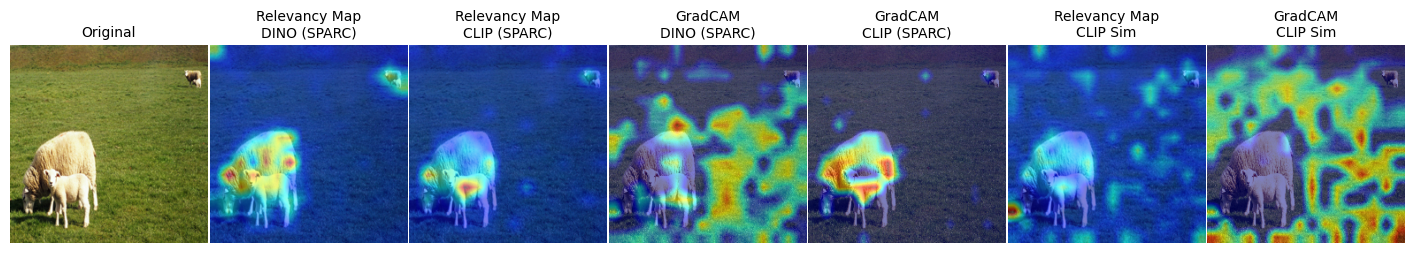

In [8]:
idx = 99863
caption = dataset[idx]['captions']
output = process_sparc(msae_global, idx, caption=caption, show_titles=True, plot_text=True, 
                       use_cross_modal=True, global_msae=True)
fig, clip_sim_relevance_latex, clip_sparc_relevance_latex, clip_sparc_gradtext_latex = output
plt.show()